In [ ]:
!pip install xgboost
!pip install shap


XGBOOST Model Performance:
              precision    recall  f1-score   support

           0       0.60      0.80      0.68       125
           1       0.24      0.11      0.15        75

    accuracy                           0.54       200
   macro avg       0.42      0.45      0.42       200
weighted avg       0.47      0.54      0.48       200


Confusion Matrix:
[[100  25]
 [ 67   8]]

Cross-validation scores: 0.605 (+/- 0.041)

RANDOM_FOREST Model Performance:
              precision    recall  f1-score   support

           0       0.62      0.98      0.76       125
           1       0.25      0.01      0.03        75

    accuracy                           0.61       200
   macro avg       0.44      0.49      0.39       200
weighted avg       0.48      0.61      0.48       200


Confusion Matrix:
[[122   3]
 [ 74   1]]

Cross-validation scores: 0.667 (+/- 0.028)


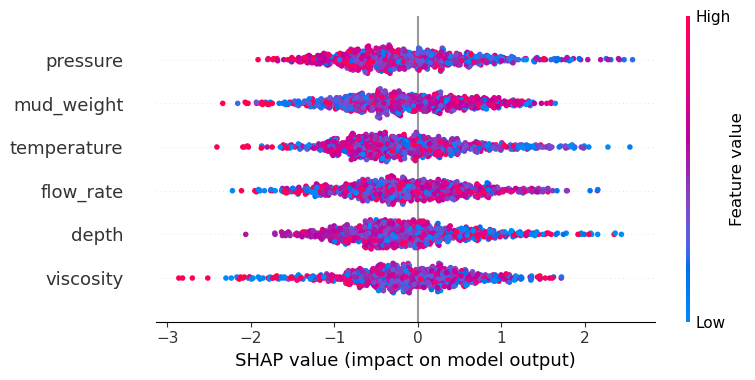

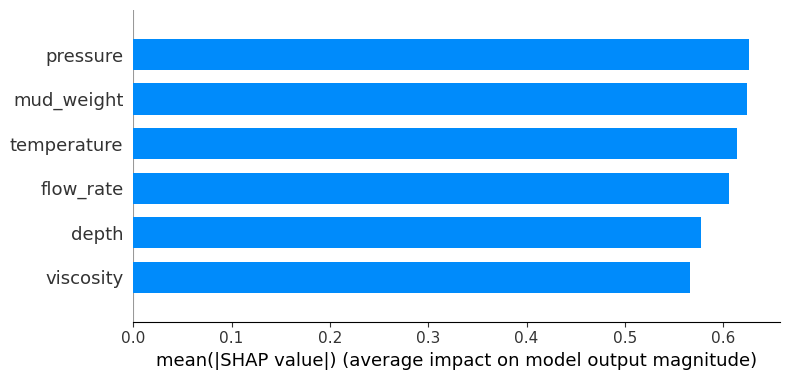


Real-time Prediction:
Risk: Low
Probability of high risk: 0.222


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
def load_and_prepare_data():
    # Sample data (replace with your actual dataset)
    data = {
        'pressure': np.random.normal(1000, 200, 1000),
        'flow_rate': np.random.normal(500, 100, 1000),
        'viscosity': np.random.normal(50, 10, 1000),
        'depth': np.random.normal(2000, 500, 1000),
        'mud_weight': np.random.normal(12, 2, 1000),
        'temperature': np.random.normal(150, 30, 1000),
        'fluid_loss_risk': np.random.choice([0, 1], 1000, p=[0.7, 0.3])
    }
    df = pd.DataFrame(data)
    return df

# 2. Data Preprocessing
def preprocess_data(df):
    X = df.drop('fluid_loss_risk', axis=1)
    y = df['fluid_loss_risk']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X, y, X_scaled, scaler

# 3. Model Training and Evaluation
def train_and_evaluate_model(X_scaled, y, model_type='xgboost'):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Initialize model
    if model_type == 'xgboost':
        model = xgb.XGBClassifier(random_state=42)
    else:
        model = RandomForestClassifier(random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation
    print(f"\n{model_type.upper()} Model Performance:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"\nCross-validation scores: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return model, X_train

# 4. SHAP Analysis
def perform_shap_analysis(model, X_train, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=X.columns)
    plt.tight_layout()
    plt.savefig('shap_summary.png')
    plt.close()
    
    # Feature importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar")
    plt.tight_layout()
    plt.savefig('shap_importance.png')
    plt.close()

# 5. Real-time Prediction Function
def predict_fluid_loss_risk(model, scaler, new_data):
    """
    Predict fluid loss risk for new drilling parameters
    new_data: dict with keys [pressure, flow_rate, viscosity, depth, mud_weight, temperature]
    """
    # Convert new data to DataFrame
    new_df = pd.DataFrame([new_data])
    
    # Scale the data
    new_scaled = scaler.transform(new_df)
    
    # Predict
    risk = model.predict(new_scaled)[0]
    probability = model.predict_proba(new_scaled)[0][1]
    
    return {
        'risk': 'High' if risk == 1 else 'Low',
        'probability': probability
    }

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    df = load_and_prepare_data()
    
    # Preprocess data
    X, y, X_scaled, scaler = preprocess_data(df)
    
    # Train and evaluate XGBoost
    xgb_model, X_train = train_and_evaluate_model(X_scaled, y, 'xgboost')
    
    # Train and evaluate Random Forest
    rf_model, _ = train_and_evaluate_model(X_scaled, y, 'random_forest')
    
    # Perform SHAP analysis for XGBoost
    perform_shap_analysis(xgb_model, X_train, X)
    
    # Example real-time prediction
    new_data = {
        'pressure': 1100,
        'flow_rate': 520,
        'viscosity': 55,
        'depth': 2100,
        'mud_weight': 12.5,
        'temperature': 160
    }
    
    prediction = predict_fluid_loss_risk(xgb_model, scaler, new_data)
    print(f"\nReal-time Prediction:")
    print(f"Risk: {prediction['risk']}")
    print(f"Probability of high risk: {prediction['probability']:.3f}")
    
    # Dashboard alert simulation
    if prediction['risk'] == 'High':
        print("\n ALERT: High fluid loss risk detected!")
        print("Recommended actions:")
        print("- Adjust mud weight")
        print("- Review flow rate parameters")
        print("- Monitor temperature closely")

	
